imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp

2025-08-15 23:43:04.282214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755281584.294649   28458 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755281584.298688   28458 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755281584.308810   28458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755281584.308828   28458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755281584.308829   28458 computation_placer.cc:177] computation placer alr

load and prepare datasets

In [2]:
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="data", download=False)

I0000 00:00:1755281589.124514   28458 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [4]:
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='subwords/imdb_vocab_subwords.txt'
)

2025-08-15 23:43:12.474902: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:324] The empty string is found in the vocabulary, which takes place in the token id space but will never be used in the result. Consider cleaning it from the vocabulary.
2025-08-15 23:43:12.475371: W tensorflow_text/core/kernels/fast_wordpiece_tokenizer_model_builder.cc:336] The empty suffix token is found in the vocabulary, which takes place in token id space but will (almost) never be used in the result. Consider cleaning it from the vocabulary.


hyperparameters

In [5]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

data - pipeline

In [6]:
def padding_func(sequences):

  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  sequences = sequences.get_single_element()

  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), 
                                                  truncating=TRUNC_TYPE, 
                                                  padding=PADDING_TYPE
                                                 )

  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [7]:
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels)

train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

2025-08-15 23:43:21.136485: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


build and compile the model

In [8]:
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 16
LSTM_DIM = 8

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'lstm output units: {LSTM_DIM}')

random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')

lstm = tf.keras.layers.LSTM(LSTM_DIM)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

lstm_rs = tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


I0000 00:00:1755281609.946706   28524 cuda_dnn.cc:529] Loaded cuDNN version 91002


In [9]:
EMBEDDING_DIM = 64
LSTM1_DIM = 32
LSTM2_DIM = 16
DENSE_DIM = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_DIM, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       488,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,017 (2.01 MB)

 Trainable params: 526,017 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train the model

In [11]:
NUM_EPOCHS = 5

history = model.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 328s 416ms/step - accuracy: 0.7118 - loss: 0.5332 - val_accuracy: 0.6364 - val_loss: 0.6086
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 325s 416ms/step - accuracy: 0.8070 - loss: 0.4223 - val_accuracy: 0.7742 - val_loss: 0.4644
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 324s 415ms/step - accuracy: 0.8893 - loss: 0.2761 - val_accuracy: 0.8048 - val_loss: 0.4962
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 325s 416ms/step - accuracy: 0.9184 - loss: 0.2150 - val_accuracy: 0.8558 - val_loss: 0.4079
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 326s 417ms/step - accuracy: 0.9333 - loss: 0.1820 - val_accuracy: 0.8512 - val_loss: 0.3948


visualize results

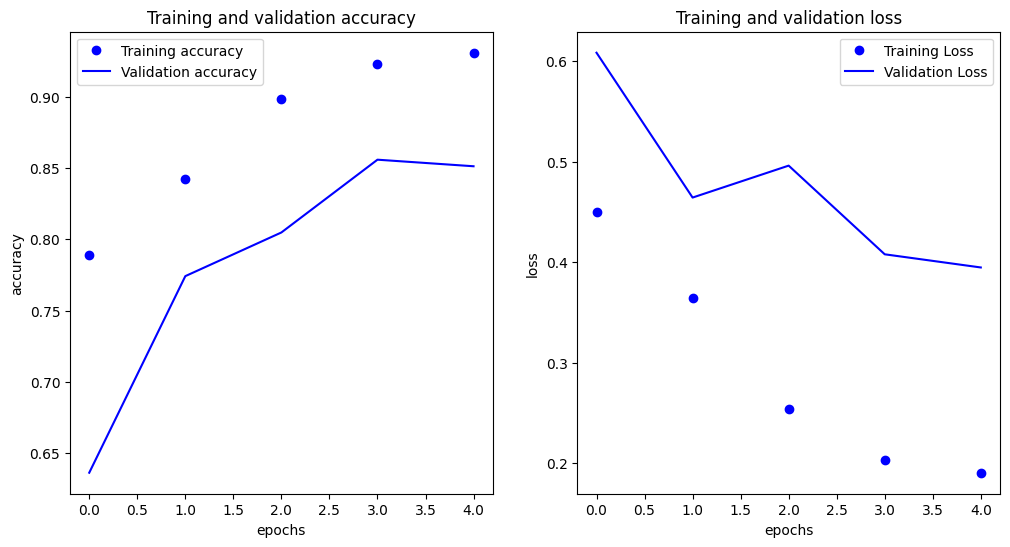

In [12]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

better results than single-layer LSTM